In [1]:
from typing import Union, Tuple, List
from PIL import Image, ImageDraw
import math
import random
from sympy import flatten
from numpy.linalg import norm

import numpy as np
from typing import List, Tuple
import math
from math import cos, sin, tan, pi
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.affinity import rotate
from shapely.ops import unary_union

import gymnasium as gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-04-30 19:29:07.139573: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 19:29:07.139892: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:29:07.144709: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:29:07.200270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:29:08.563706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

# First Attempt

In [ ]:
# Finds the straight-line distance between two points
def dist(ax, ay, bx, by):
    # return norm(np.array((ax, ay))-np.array((bx, by)))
    return math.sqrt((by - ay)**2 + (bx - ax)**2)

# Rotates point `A` about point `B` by `angle` radians clockwise.
def rotated_about(ax, ay, bx, by, angle):
    radius = dist(ax,ay,bx,by)
    angle += math.atan2(ay-by, ax-bx)
    return (
        round(bx + radius * math.cos(angle)),
        round(by + radius * math.sin(angle))
    )


In [21]:

# Credit for this function goes to ChatGPT
'''
def overlap_area(squares: List[Tuple[float, float, float]]) -> float:
    # Create a dictionary to keep track of the number of squares overlapping each point
    overlap_counts = {}

    for rotated_corners in compute_corners(squares):
        # Add 1 to the overlap count for each point that this square covers
        for i in range(len(rotated_corners)):
            p1, p2 = rotated_corners[i], rotated_corners[(i+1)%len(rotated_corners)]
            for x in range(math.ceil(min(p1[0], p2[0])), math.floor(max(p1[0], p2[0]))):
                for y in range(math.ceil(min(p1[1], p2[1])), math.floor(max(p1[1], p2[1]))):
                    if (x, y) in overlap_counts:
                        overlap_counts[(x, y)] += 1
                    else:
                        overlap_counts[(x, y)] = 1

    # Compute the total area of overlap by summing the area of each overlapping square
    overlap_area = 0
    for count in overlap_counts.values():
        if count > 1:
            overlap_area += 1

    return overlap_area
 '''
'''
def compute_intersection(p1, q1, p2, q2):
    x1, y1 = p1
    x2, y2 = q1
    x3, y3 = p2
    x4, y4 = q2

    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0:
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom

    if 0 <= ua <= 1 and 0 <= ub <= 1:
        return (x1 + ua*(x2-x1), y1 + ua*(y2-y1))
    else:
        return None


def overlap_area(squares: List[Tuple[float, float, float]]) -> float:
    # Create a set to keep track of all the overlapping points
    overlap_points = set()

    # Iterate over all pairs of squares
    for i in range(len(squares)):
        for j in range(i+1, len(squares)):
            # Compute the corners of each square
            corners_i = compute_corners([squares[i]])[0]
            corners_j = compute_corners([squares[j]])[0]

            # Iterate over all pairs of edges
            for k in range(len(corners_i)):
                for l in range(len(corners_j)):
                    # Compute the intersection point of the edges
                    p = compute_intersection(corners_i[k], corners_i[(k+1)%len(corners_i)], corners_j[l], corners_j[(l+1)%len(corners_j)])
                    if p is not None:
                        overlap_points.add(p)

    # Compute the total area of overlap as the sum of the areas of the triangles formed by each set of three adjacent points
    overlap_area = 0
    overlap_points = sorted(list(overlap_points))
    for i in range(1, len(overlap_points)-1):
        a, b, c = overlap_points[i-1], overlap_points[i], overlap_points[i+1]
        overlap_area += abs((b[0]-a[0])*(c[1]-a[1]) - (c[0]-a[0])*(b[1]-a[1]))/2

    return overlap_area
 '''
from shapely.geometry import Polygon, MultiPolygon
'''
def get_overlapping_polygons(squares: List[Tuple[float, float, float]]) -> List[Polygon]:
    polygons = []
    for square in squares:
        x, y, rad = square
        # calculate the coordinates of the four corners of the square
        p1 = (x + 0.5 * cos(rad - pi / 4), y + 0.5 * sin(rad - pi / 4))
        p2 = (x + 0.5 * cos(rad + pi / 4), y + 0.5 * sin(rad + pi / 4))
        p3 = (x + 0.5 * cos(rad + 3 * pi / 4), y + 0.5 * sin(rad + 3 * pi / 4))
        p4 = (x + 0.5 * cos(rad - 3 * pi / 4), y + 0.5 * sin(rad - 3 * pi / 4))
        # create a polygon from the four corners
        polygon = Polygon([p1, p2, p3, p4])
        # check if this polygon overlaps with any of the previously created polygons
        overlaps = False
        for p in polygons:
            if polygon.intersects(p):
                overlaps = True
                # merge the overlapping polygons
                polygon = polygon.union(p)
                polygons.remove(p)
        if not overlaps:
            # add the polygon to the list
            polygons.append(polygon)
    return polygons
 '''

def convert2shapely(squares:List[Tuple[float, float, float]], side_len:float=1.0) -> List[Polygon]:
    return [Polygon(corners) for corners in compute_corners(squares, sideLen=side_len)]

def get_overlapping_polygons(squares: List[Tuple[float, float, float]], side_len: float = 1.0) -> List[Polygon]:
    overlap = []
    squares = convert2shapely(squares)
    for p1 in squares:
        for p2 in squares:
            if p1 == p2:
                continue
            if p1.intersects(p2):
                print('Intersection detected')
                overlap.append(p1.union(p2))
    return overlap

    # for x, y, rad in squares:
    #     # compute the corners of the square based on its center and orientation
    #     corners = compute_corners([square], side_len)[0]
    #     # create a polygon from the corners
    #     polygon = Polygon(corners)
    #     # check if this polygon overlaps with any of the previously created polygons
    #     overlaps = False
    #     for p in polygons:
    #         if polygon.intersects(p):
    #             overlaps = True
    #             # merge the overlapping polygons
    #             polygon = polygon.union(p)def drawBox(draw, x, y, rot, sideLen):
    square_vertices = (
        (x + sideLen / 2, y + sideLen / 2),
        (x + sideLen / 2, y - sideLen / 2),
        (x - sideLen / 2, y - sideLen / 2),
        (x - sideLen / 2, y + sideLen / 2)
    )

    square_vertices = [rotated_about(_x, _y, x, y, rot) for _x, _y in square_vertices]
    draw.polygon(square_vertices, fill='#FF7B00')


def graphBoxes(squares:List[Tuple['x','y','rad']], squareSize=20, verbose=False):
    print(f'Size is: {get_bounding_box(compute_corners(squares, squareSize), square=True):.3f}')
    print(f'Overlapping area is: {overlap_area(squares)}')
    print(f'Wasted Space is: ')

    # Create image
    image = Image.new("RGB", (200, 200), "white")
    draw = ImageDraw.Draw(image)

    # Do some calculations
    corners = compute_corners(squares, squareSize)
    cornersX, cornersY = np.array(corners).T
    bottomRight = cornersX.max(), cornersY.max()
    topLeft = cornersX.min(), cornersY.min()

    # Draw all the boxes
    for x, y, rad in squares:
        drawBox(draw, x, y, rad, squareSize)

    if verbose:
        # Draw the corners
        for x, y in flatten(corners, levels=1):
            draw.ellipse((x-2, y-2, x+2, y+2), fill='#3DAEE9')

        # Draw the bounding box corners
        for x, y in (topLeft, bottomRight):
            draw.ellipse((x-2, y-2, x+2, y+2), fill='#F4C02C')

        # Draw bounding box
        w, h = get_bounding_box(corners, square=False)
        draw.rectangle((topLeft, (topLeft[0]+w, topLeft[1]+h)), outline='#383838')

        # Draw bounding square
        w = get_bounding_box(corners, square=True)
        draw.rectangle((topLeft, (topLeft[0]+w, topLeft[1]+w)), outline='#8399A4')

        # Draw the overlapping areas
        for polygon in get_overlapping_polygons(squares, side_len=squareSize):
            vertices = polygon.exterior.coords
            # draw the polygon using the polygon method
            draw.polygon(vertices, fill=(255, 0, 0, 128), outline=(255, 0, 0, 255))

    return image

sqs = convert2shapely([(random.uniform(50, 150), random.uniform(50, 150), random.uniform(1, 2*math.pi)) for i in range(5)])
graphBoxes(sqs, verbose=True)
    #             polygons.remove(p)
    #     if not overlaps:
    #         # add the polygon to the list
    #         polygons.append(polygon)
    # return polygons

TypeError: cannot unpack non-iterable Polygon object

In [ ]:
# convert2shapely([(random.uniform(50, 150), random.uniform(50, 150), random.uniform(1, 2*math.pi)) for i in range(4)])[0]

In [3]:
def get_bounding_box(corners, square=False):
    x, y = np.array(corners).T
    if square:
        return max(x.max() - x.min(), y.max() - y.min())
    else:
        return x.max() - x.min(), y.max() - y.min()


In [19]:
def drawBox(draw, polygon):
    square_vertices = (
        (x + sideLen / 2, y + sideLen / 2),
        (x + sideLen / 2, y - sideLen / 2),
        (x - sideLen / 2, y - sideLen / 2),
        (x - sideLen / 2, y + sideLen / 2)
    )

    square_vertices = [rotated_about(_x, _y, x, y, rot) for _x, _y in square_vertices]
    draw.polygon(polygon.exterior.coords, fill='#FF7B00')


def graphBoxes(squares:MultiPolygon, squareSize=20, verbose=False):
    print(f'Size is: {get_bounding_box(compute_corners(squares, squareSize), square=True):.3f}')
    print(f'Overlapping area is: {overlap_area(squares)}')
    print(f'Wasted Space is: ')

    # Create image
    image = Image.new("RGB", (200, 200), "white")
    draw = ImageDraw.Draw(image)

    # Do some calculations
    corners = compute_corners(squares, squareSize)
    cornersX, cornersY = np.array(corners).T
    bottomRight = cornersX.max(), cornersY.max()
    topLeft = cornersX.min(), cornersY.min()

    # Draw all the boxes
    for x, y, rad in squares:
        drawBox(draw, x, y, rad, squareSize)

    if verbose:
        # Draw the corners
        for x, y in flatten(corners, levels=1):
            draw.ellipse((x-2, y-2, x+2, y+2), fill='#3DAEE9')

        # Draw the bounding box corners
        for x, y in (topLeft, bottomRight):
            draw.ellipse((x-2, y-2, x+2, y+2), fill='#F4C02C')

        # Draw bounding box
        w, h = get_bounding_box(corners, square=False)
        draw.rectangle((topLeft, (topLeft[0]+w, topLeft[1]+h)), outline='#383838')

        # Draw bounding square
        w = get_bounding_box(corners, square=True)
        draw.rectangle((topLeft, (topLeft[0]+w, topLeft[1]+w)), outline='#8399A4')

        # Draw the overlapping areas
        for polygon in get_overlapping_polygons(squares, side_len=squareSize):
            vertices = polygon.exterior.coords
            # draw the polygon using the polygon method
            draw.polygon(vertices, fill=(255, 0, 0, 128), outline=(255, 0, 0, 255))

    return image

sqs = convert2shapely([(random.uniform(50, 150), random.uniform(50, 150), random.uniform(1, 2*math.pi)) for i in range(5)], side_len=20)
graphBoxes(sqs, verbose=True)

TypeError: cannot unpack non-iterable Polygon object

In [5]:
def drawBox(draw, x, y, rot, sideLen):
    square_vertices = (
        (x + sideLen / 2, y + sideLen / 2),
        (x + sideLen / 2, y - sideLen / 2),
        (x - sideLen / 2, y - sideLen / 2),
        (x - sideLen / 2, y + sideLen / 2)
    )

    square_vertices = [rotated_about(_x, _y, x, y, rot) for _x, _y in square_vertices]
    draw.polygon(square_vertices, fill='#FF7B00')


def graphBoxes(squares:List[Tuple['x','y','rad']], squareSize=20, verbose=False):
    print(f'Size is: {get_bounding_box(compute_corners(squares, squareSize), square=True):.3f}')
    print(f'Overlapping area is: {overlap_area(squares)}')
    print(f'Wasted Space is: ')

    # Create image
    image = Image.new("RGB", (200, 200), "white")
    draw = ImageDraw.Draw(image)

    # Do some calculations
    corners = compute_corners(squares, squareSize)
    cornersX, cornersY = np.array(corners).T
    bottomRight = cornersX.max(), cornersY.max()
    topLeft = cornersX.min(), cornersY.min()

    # Draw all the boxes
    for x, y, rad in squares:
        drawBox(draw, x, y, rad, squareSize)

    if verbose:
        # Draw the corners
        for x, y in flatten(corners, levels=1):
            draw.ellipse((x-2, y-2, x+2, y+2), fill='#3DAEE9')

        # Draw the bounding box corners
        for x, y in (topLeft, bottomRight):
            draw.ellipse((x-2, y-2, x+2, y+2), fill='#F4C02C')

        # Draw bounding box
        w, h = get_bounding_box(corners, square=False)
        draw.rectangle((topLeft, (topLeft[0]+w, topLeft[1]+h)), outline='#383838')

        # Draw bounding square
        w = get_bounding_box(corners, square=True)
        draw.rectangle((topLeft, (topLeft[0]+w, topLeft[1]+w)), outline='#8399A4')

        # Draw the overlapping areas
        for polygon in get_overlapping_polygons(squares, side_len=squareSize):
            vertices = polygon.exterior.coords
            # draw the polygon using the polygon method
            draw.polygon(vertices, fill=(255, 0, 0, 128), outline=(255, 0, 0, 255))

    return image

sqs = [(random.uniform(50, 150), random.uniform(50, 150), random.uniform(1, 2*math.pi)) for i in range(5)]
graphBoxes(sqs, verbose=True)

NameError: name 'compute_corners' is not defined

# Setting up the loss function

In [18]:
def compute_corners(squares: List[Tuple[float, float, float]], sideLen=1):
    rtn = []
    for x, y, rot_rad in squares:
        # Compute the coordinates of the four corners of the square
        half_side = sideLen / 2
        corners = [(half_side, half_side), (half_side, -half_side), (-half_side, -half_side), (-half_side, half_side)]
        rotated_corners = []
        for corner in corners:
            rotated_x = x + corner[0]*math.cos(rot_rad) - corner[1]*math.sin(rot_rad)
            rotated_y = y + corner[0]*math.sin(rot_rad) + corner[1]*math.cos(rot_rad)
            rotated_corners.append((rotated_x, rotated_y))
        rtn.append(rotated_corners)
    return rtn

In [6]:
def overlap_area(multi):
    overlapArea = 0
    for i, square1 in enumerate(multi.geoms):
        for square2 in list(multi.geoms)[i+1:]:
            if square1.intersects(square2):
                overlapArea += square1.intersection(square2).area
    return overlapArea

def side_len(polygon):
    x, y = polygon.minimum_rotated_rectangle.exterior.coords.xy
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_length)

def wasted_space(multi):
    side = side_len(multi)
    return side**2 - multi.area

In [7]:
def lossFunc(squares:MultiPolygon):
    score = 0
    if not squares.is_valid:
        # We don't like it when they overlap at all
        score -= 1000
        # We don't like it when they overlap a lot
        score -= math.e**overlap_area(squares)

    score -= wasted_space(squares)
    score -= side_len(squares)
    return score

In [8]:
N=11
verbose = True
scale = 1
space = N*scale # Optimal: 3.789, best known: 3.877084
seed = 42

In [15]:
# This is useful. I don't know *how*, but it's got to be somehow
# squares.convex_hull
squares = MultiPolygon(convert2shapely([(random.uniform(0, space), random.uniform(0, space), random.uniform(1, 2*math.pi)) for i in range(N)], side_len=scale))

if verbose:
    display(unary_union((squares, squares.minimum_rotated_rectangle.exterior)))
else:
    display(squares)

print(f'Overlaps: {not squares.is_valid}')
print(f'Overlap Area: {overlap_area(squares):.3f}')
print(f'Side Length: {side_len(squares):.3f}')
print(f'Wasted Space: {wasted_space(squares):.2f}')
print(f'Loss: {lossFunc(squares)}')


NameError: name 'compute_corners' is not defined

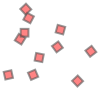

In [30]:
squares = MultiPolygon(convert2shapely([(random.uniform(0, space), random.uniform(0, space), random.uniform(1, 2*math.pi)) for i in range(N)], side_len=scale))
squares

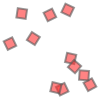

In [23]:
squares

# Testing gym

In [10]:
# !pip install gymnasium
from typing import Union, Tuple, List
from PIL import Image, ImageDraw
import math
import random
from sympy import flatten
from numpy.linalg import norm

import numpy as np
from typing import List, Tuple
import math
from math import cos, sin, tan, pi
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.affinity import rotate
from shapely.ops import unary_union

import gymnasium as gym

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
%load_ext autoreload
%autoreload 2
!pip install -e SquarePacking

Defaulting to user installation because normal site-packages is not writeable
ERROR: SquarePacking is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [11]:
# from SquarePacking.SquarePacking.SquareEnv import SquareEnv
import SquarePacking.env
import gymnasium as gym
seed = 42

env = gym.make("SquarePacking/Square-v0", N=10, render_mode="pygame", shift_rate=.05, rot_rate=.05, bound_method='loop', flatten=True, boundary=1)
display(env.reset())
# env = SquareEnv(N=4, search_space=None, shift_rate=.01, rot_rate=.001)

ModuleNotFoundError: No module named 'SquarePacking'

In [12]:
import time

# action = np.array([(
#             random.uniform(-env.shift_rate, env.shift_rate),
#             random.uniform(-env.shift_rate, env.shift_rate),
#             random.uniform(-env.rot_rate,   env.rot_rate)
#         ) for _ in range(env.N)])

env.reset()
action = np.array([(-env.shift_rate, -env.shift_rate, -env.rot_rate) for _ in range(env.N)]).flatten()

for _ in range(200):
    time.sleep(.02)
    obs, reward, done, _, info = env.step(action)
    # print(obs[0])
env.close()

NameError: name 'env' is not defined

In [14]:
env.close()

NameError: name 'env' is not defined

In [13]:
pygame_surface = pygame.image.load(io.BytesIO(env.squares.svg(20, '#d12d2d', 175).encode()))

NameError: name 'pygame' is not defined